
Hello again.

Now that we know what an encoder looks like, let us use one on some image data. 

The go-to image data is of course MNIST. Boring!

In this practical, we will:

 - Use a simple dense AE on MNIST
 - Visualise the low-dim representation of the data
 
 

In [17]:
# Load MNIST data here
# There are many ways to do that
# I made a copy for you which you can download from:
#   http://www.fmrib.ox.ac.uk/~saad/mnist.npz


import numpy as np
# Assuming you are me and have saved the data on the Desktop
data = np.load('/Users/saad/Downloads/mnist.npz')

# Training/Testing data
X_train = data['x_train']
X_test  = data['x_test']

# Vectorise images (28x28 -> 784)
image_size  = X_train.shape[1]
input_dim   = image_size * image_size
X_train     = np.reshape(X_train, [-1, input_dim])
X_test      = np.reshape(X_test, [-1, input_dim])

# Rescale between 0 and 1 (always a good idea in deep nets)
X_train     = X_train / 255.0
X_test      = X_test  / 255.0



Bit of a helper code for visualisation of images

In [19]:
# display a nxn grid of images

import matplotlib.pyplot as plt

# Assumes shape of X is [Nimages,pixels*pixels]
def gridplot(X,im_size,n=10):

    pad_size = 5
    figure = np.zeros((pad_size + (im_size+pad_size) * n, 
                       pad_size + (im_size+pad_size) * n))

    cnt = 0
    ii = pad_size
    for i in range(n):
        jj = pad_size 
        for j in range(n):
            if(cnt<X.shape[0]):                
                image = np.reshape(X[cnt,...],(im_size,im_size))
                figure[ii:ii+im_size,jj:jj+im_size] = image
            
            jj += (im_size+pad_size)
            cnt += 1
            
        ii += (im_size+pad_size)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()



Now let us set up an Autoencoder

In [20]:

from keras.layers import Input, Dense
from keras.models import Model

# Input -> Interm_layer -> LowDim -> Interm_layer ->  Output
def create_AE(input_dim,intermediate_dim=256,latent_dim=2):
    
    # Encoder Model
    inputs    = Input(shape=(input_dim,))
    x         = Dense(intermediate_dim, activation='relu')(inputs)
    z         = Dense(latent_dim, activation='linear')(x)
   
    enc       = Model(inputs, z, name='encoder')

    # Decoder model
    latent_inputs = Input(shape=(latent_dim,))
    x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs       = Dense(input_dim, activation='sigmoid')(x)
    
    dec           = Model(latent_inputs, outputs, name='decoder')
    
    # instantiate AE model
    outputs = dec(enc(inputs))
    ae      = Model(inputs, outputs, name='ae')
    
    return ae,enc,dec


In [21]:
# Create Autoencoder
ae,enc,dec = create_AE(input_dim=X_train.shape[1])

ae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 201474    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


I will leave the calculation of the number of parameters as an exercise.... 

Now we need a loss function as before.


In [22]:
from keras.losses import mse
from keras import backend as K

# This is the mean squared error loss function to be minimized
def recon_loss(inputs,outputs):
    reconstruction_loss = mse(inputs, outputs)
    
    return K.mean(reconstruction_loss)


In [23]:
# Train it

# Defining loss function
losses = {'decoder':recon_loss}

# Defining optimisation routine
ae.compile(optimizer='adam',loss=losses)

# Fitting with stochastic gradient descent
# (this will take a few minutes)
ae.fit(X_train,
        {'decoder':X_train},
        epochs=60,            
        batch_size=128,shuffle=True)



Epoch 1/60
60000/60000 [==============================] - 4s 64us/step - loss: 0.0636
Epoch 2/60
60000/60000 [==============================] - 4s 61us/step - loss: 0.0519
Epoch 3/60
60000/60000 [==============================] - 4s 70us/step - loss: 0.0486
Epoch 4/60
60000/60000 [==============================] - 4s 59us/step - loss: 0.0468
Epoch 5/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.0458
Epoch 6/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.0450
Epoch 7/60
60000/60000 [==============================] - 4s 58us/step - loss: 0.0445
Epoch 8/60
60000/60000 [==============================] - 4s 59us/step - loss: 0.0440
Epoch 9/60
60000/60000 [==============================] - 4s 63us/step - loss: 0.0437
Epoch 10/60
60000/60000 [==============================] - 4s 59us/step - loss: 0.0433
Epoch 11/60
60000/60000 [==============================] - 4s 60us/step - loss: 0.0430
Epoch 12/60
60000/60000 [===========================

let's have a look at the lowdim space using the test data

We have an AE that does DATA --> Z --> DATA_PRED where Z lives in a lowdim space. 


In [7]:

# encode
z = enc.predict(X_test)

# scatter with colour-coding
plt.scatter(z[:,0],z[:,1],c=data['y_test']) 
plt.colorbar()
plt.show()


It looks like it is able to distinguish the different numbers (we have not told it what the numbers are so this is purely based on what the numbers look like, i.e. the pixel values)

But it also looks like the numbers are spread out in a star-shaped manner. What we really want is to understand the low dimensional data manifold so we can e.g. interpolate between the categories and have something continuous going on. That is what Variational AEs are trying to do. But let's not get ahead of ourselves...

Next we plot the images *given* the values of Z: 

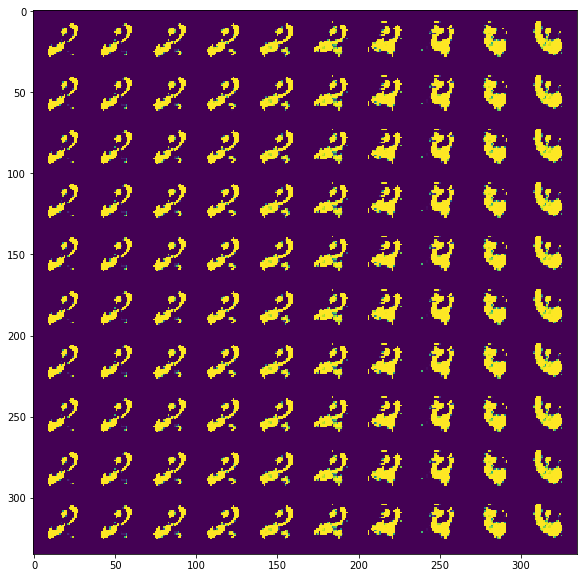

In [25]:
# Now let us 'generate' images from the lowdim space

# Grid of z samples
x   = np.linspace(-20, 80, 10)
y   = np.linspace(-175, 0, 10)
x,y = np.meshgrid(x,y)
z   = np.concatenate((x.flatten()[:,None],y.T.flatten()[:,None]),axis=1)

# Decode images
X = dec.predict(z)

# Visualise
gridplot(X,28)


Not so great.... 


Let's Look at the output of an input
    

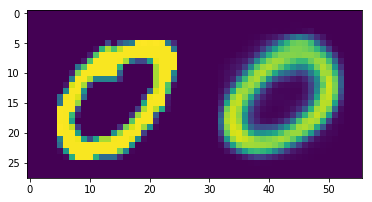

In [35]:
pred = ae.predict(X_test)

random_index = np.random.randint(X_test.shape[0])
plt.imshow(np.concatenate((X_test[random_index,:].reshape((28,28)),
                            pred[random_index,:].reshape((28,28))),axis=1))

Still getting quite confused. I suspect a convnet might do better, but this practical is not about convnets :)


Okay - that's enough playing with AEs.  Next we do VAEs.
